In [2]:
import os, sys, inspect       # For importing the submodules in a platform-independend robust way
# Make sure that the path to BlenDaViz and the integration library are in the front of the path.
code_folder = os.path.realpath(os.path.abspath(os.path.join(os.path.split(inspect.getfile( inspect.currentframe() ))[0],".")))
if code_folder not in sys.path:
     sys.path.insert(0, code_folder)

import numpy as np
import matplotlib.pyplot as plt
from functools import partial  # create new funtions from old functions (and strip the kwargs)
from scipy.integrate import odeint
import cmath 
import sympy as sym
import frenet_serret

In [3]:
def random_three_vector():
    """
    Generates a random 3D unit vector (direction) with a uniform spherical distribution
    Algo from http://stackoverflow.com/questions/5408276/python-uniform-spherical-distribution
    :return:
    """
    phi = np.random.uniform(0,np.pi*2)
    costheta = np.random.uniform(-1,1)
    theta = np.arccos( costheta )
    x = np.sin( theta) * np.cos( phi )
    y = np.sin( theta) * np.sin( phi )
    z = np.cos( theta )
    return np.array((x,y,z))

In [4]:
def Kedia_32(xx):
    '''
    Vector field whose integral curves lie on knotted trefoil surfaces
    See Kedia et al. 10.1103/PhysRevLett.111.150404
    '''
    vv = np.zeros(3)
    vv[0] = (192*(2*xx[0]**5*xx[1] + xx[0]**3*xx[1]*(-1 + xx[2]**2) - 2*xx[1]**2*xx[2]*(-1 + xx[1]**2 + xx[2]**2) + 2*xx[0]**2*xx[2]*(-1 + 3*xx[1]**2 + xx[2]**2) - xx[0]*xx[1]*(1 + 2*xx[1]**4 - 6*xx[2]**2 + xx[2]**4 + 3*xx[1]**2*(-1 + xx[2]**2))))/(1 + xx[0]**2 + xx[1]**2 + xx[2]**2)**6

    vv[1] = -((96*(xx[0]**6 + 12*xx[0]**3*xx[1]*xx[2] - 4*xx[0]*xx[1]*xx[2]*(2 + xx[1]**2 - 2*xx[2]**2) + xx[0]**4*(-2 - 5*xx[1]**2 + 2*xx[2]**2) + xx[1]**2*(-1 + xx[1]**4 + 6*xx[2]**2 - xx[2]**4) + xx[0]**2*(1 - 5*xx[1]**4 - 6*xx[2]**2 + xx[2]**4 - 6*xx[1]**2*(-1 + xx[2]**2))))/(1 + xx[0]**2 + xx[1]**2 + xx[2]**2)**6)

    vv[2] = -((192*(xx[0]**5 - 3*xx[0]**4*xx[1]*xx[2] + xx[0]**2*xx[1]*xx[2]*(9 - 2*xx[1]**2 - 3*xx[2]**2) + xx[1]**3*xx[2]*(-3 + xx[1]**2 + xx[2]**2) + xx[0]**3*(-1 - 2*xx[1]**2 + 3*xx[2]**2) - 3*xx[0]*xx[1]**2*(-1 + xx[1]**2 + 3*xx[2]**2)))/(1 + xx[0]**2 + xx[1]**2 + xx[2]**2)**6)
    return vv/np.sum(np.sqrt(vv**2))

In [5]:
def fieldline(start=np.array([np.random.random_sample(),0,0]), field=Kedia_32, N=100, tf=100):
    numargs = len(inspect.signature(field).parameters)
    if numargs == 1:
        # replace with function with proper call signature
        print('adding time dependence to the function')
        placeholder = field
        field = lambda xx, t: placeholder(xx)
    elif numargs > 2:
        print("Error: function call signature takes too many arguments")
        raise TypeError
    print(start)
    print(field(start, 0))
    t = np.linspace(0, tf, N)
    X = odeint(field, start, t, hmax=0.05, rtol=1e-10)
    return X

magneticAxis = fieldline(start=np.array([1.07222,0.71903,0.816497]), field=Kedia_32, N=100, tf=100)


adding time dependence to the function
[1.07222  0.71903  0.816497]
[ 9.13841762e-01 -8.61542801e-02  3.95748842e-06]


In [6]:
def fieldline2ListOfPoints(thisFieldline):
    """
    return the fieldline, which is a nx3 array
    as a list (length n) of points
    """
    return [thisFieldline[n,:] for n in range(thisFieldline.shape[0])]

In [7]:
def calculateTangents(points, function):
    """
    return the tangents of a field line
    by evaluating the function at points
    arguments:
    *points*: 3-arrays where the field is to be evaluated
    *function*: the function that was integrated to generate the points
    """
    #Evaluate the function at point, and use fancy-schmancy
    #python array-casting to make a list of this for every point. 
    tangents = [function(point) for point in points]
    return tangents

In [8]:
def dToPlane(dispoint, point, normal):
    return np.dot((dispoint-point),normal)

In [9]:
def getPositiveCrossings(points, point, normal):
    """
    returns the indexes in the streamline array where the crossings occur
    The crossing occurs between this index and next index.
    """
    sides = np.dot( (points-point), normal)<0 #calculate the side of the plane each point falls on by projecting on the normal vector
    return np.flatnonzero((sides[:-1]^sides[1:])) #calculate the xor of the boolean array that is 1 if it is above the plane with itself bitshifted. nonzero elements is where a crossing through the plane has taken place. Last and picks only crossings from positive to negative. flatnonzero returns indices of elements that are nonzero.


def pointOnPlane(p1, p2, point, normal):
    """
    calculate the point on the plane that is between the two points.
    """
    if np.sign(dToPlane(p1, point, normal))== np.sign(dToPlane(p2, point, normal)):
        print ('WARNING: POINTS NOT ON DIFFERENT SIDE OF PLANE')
        return
    linevec = p1-p2 #vector along the line
    distance =(np.dot( (point - p1),normal))/(np.dot(linevec, normal)) #see wikipedia, Line-plane_intersection
    
    return distance*linevec + p1

In [10]:
def getAnglefromSegmentCrossingFrame(segment, frame): #function that takes a line segment and corresponding frame 
    """
    A function takes a line segment from a larger field line array and a corresponding frame and calculates the crossing index and angle within the frame
    """
    
    crossingIndices = getPositiveCrossings(segment, frame.position, frame.tangent)
    
    if len(crossingIndices)==0:
        print('Warning! No crossing between segment and frame found! Try changing segment length.')
        
    if len(crossingIndices)>1:
        print('Warning! More than one crossing found! Try changing segment length.')
    
    crossCoord = pointOnPlane(segment[crossingIndices[0]], segment[crossingIndices[0]+1], frame.position, frame.tangent)
    
    normalProjection = np.dot(crossCoord - frame.position, frame.normal)
    binormalProjection = np.dot(crossCoord - frame.position, frame.binormal)
        
    crossingIndex = crossingIndices[0]
    
    angle = np.arctan2(normalProjection, binormalProjection)
    
    return angle, crossingIndex

In [39]:
tangents = calculateTangents(fieldline2ListOfPoints(magneticAxis), Kedia_32)
frames = frenet_serret.computeFrenetSerretFrames(magneticAxis[:31], tangents[:31]) 
stepSize = 0.1
points = fieldline(start=np.array(frames[0].position + frames[0].normal * stepSize), field=Kedia_32, N=1000, tf=100)


def rotationalTransform(points, frames):
    """
    calculates the rotational transform of a field line described by points around the core field line specified by frames
    """
    angles = []
    currentPosition = 1 #first point after 0th frame
    currentFrameNumber = 1
    searchForward = 35
    searchBack = 15
    numFrames = len(frames)
    
    while currentPosition < len(points) - (searchForward+1):

        segment = points[max(currentPosition-searchBack, 0) : currentPosition+searchForward] #creates an array of 16 points on the Field Line which will be used to find the crossings of the Field Line and the Frenet-Serret Frames

        currentFrame = frames[currentFrameNumber]
        
        angle, crossingIndex = getAnglefromSegmentCrossingFrame(segment, currentFrame)
        
        currentFrameNumber = (currentFrameNumber + 1) % (numFrames)
        currentPosition = currentPosition + crossingIndex +1
        
        angles.append(angle)
    angles = np.array(angles)
    angleDiff = (angles[1:]-angles[:-1])%(2*np.pi) #the difference between an angle and the angle before
    
    angleDiff = angleDiff - 2*np.pi
    
    numCompleteTurns = int((len(angles)/(numFrames))) #int throws away everything after the decimal 
    
    TotalAngle = sum(angleDiff[:numCompleteTurns*numFrames - 2]) #subtract 2 because angleDiff has one less element than angles and python is 0-indexed
    
    RotationalTransform = (TotalAngle / (numCompleteTurns * (2*np.pi)))
    
    return RotationalTransform

[ 9.95585329e-01 -9.38608201e-02  4.31148758e-06] [ 4.29245378e-06 -4.04679761e-07 -1.00000000e+00] [ 9.38608201e-02  9.95585329e-01 -5.29395592e-23]
0.1172689443129902
adding time dependence to the function
[1.07222043 0.71902996 0.716497  ]
[ 0.91515755 -0.03097281 -0.05386964]


[ 9.95585329e-01 -9.38608201e-02  4.31148758e-06] [ 4.29245378e-06 -4.04679761e-07 -1.00000000e+00] [ 9.38608201e-02  9.95585329e-01 -5.29395592e-23]
0.1172689443129902
adding time dependence to the function
[1.07222004 0.71903    0.806497  ]
[ 0.91387783 -0.08062859 -0.00549358]
adding time dependence to the function
[1.07222009 0.71902999 0.796497  ]
[ 0.91392148 -0.07510812 -0.01097039]
adding time dependence to the function
[1.07222013 0.71902999 0.786497  ]
[ 0.9139826  -0.06959221 -0.01642518]
adding time dependence to the function
[1.07222017 0.71902998 0.776497  ]
[ 0.914064   -0.06407942 -0.02185658]
adding time dependence to the function
[1.07222021 0.71902998 0.766497  ]
[ 0.91416864 -0.0585682  -0.02726317]
adding time dependence to the function
[1.07222026 0.71902998 0.756497  ]
[ 0.91429967 -0.05305688 -0.03264345]
adding time dependence to the function
[1.0722203  0.71902997 0.746497  ]
[ 0.91446043 -0.04754368 -0.03799589]
adding time dependence to the function
[1.07222

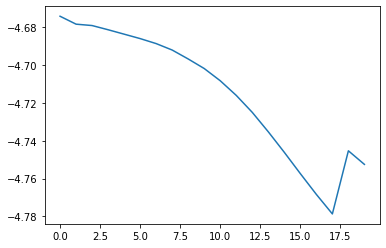

In [40]:
##Comparing the rotational transform and stepSize
rotationalTransforms = []
tangents = calculateTangents(fieldline2ListOfPoints(magneticAxis), Kedia_32)
frames = frenet_serret.computeFrenetSerretFrames(magneticAxis[:31], tangents[:31])

for stepSize in np.linspace(0.01, 0.2, 20): 
    points = fieldline(start=np.array(frames[0].position + frames[0].normal * stepSize), field=Kedia_32, N=1000, tf=100)

    rotationalTransforms.append(rotationalTransform(points, frames))

plt.plot(rotationalTransforms)